In [252]:
import pyodbc
from numpy import vectorize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#from pandas.tseries.offsets import BDay
from datetime import datetime
from os import getcwd
from sqlalchemy.engine import URL
from sqlalchemy import create_engine
from UliPlot.XLSX import auto_adjust_xlsx_column_width

SQL

In [178]:
# Get GMLA list and GMLA system date
cklist_confirm_query = """ 
SELECT [projectSizeId]
      ,[PROJECT_SIZE_NAME] as 'Project_Name'
      ,[PROJECT_CATEGORY] as 'Segment'
      ,LEFT([typeName],4) + Right([typeName],1) as 'Phase'
      ,[status]
      /*,[rejectReason]*/
      /*,[kickOffMeetingDate]*/
      ,[baseOverDueDate] as 'actualCloseMeetingDate'
      /*,[submitDate] as 'actualGMLASubmitDate'*/
      /*,[IsByPass]*/
  FROM [PR_WEB2].[dbo].[T_GMLA_CKLIST_CONFIRM]

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on projectSizeId = PROJECT_SIZE_ID
  /* Join project names and segment */

  LEFT JOIN [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE]
  ON typeId = [PR_WEB2].[dbo].[T_GMLA_BS_VERSION_TYPE].id
  /* Join GMLA#1/#2/#3 name*/

  WHERE [IsByPass] = '0'
"""

# Get design review date which sync PM system
project_schedule_query = """ 
SELECT [ProjectSizeId] as 'projectSizeId'
      /*
      ,[PROJECT_NAME]
      ,[T_GT_ProjectSchedule].[TASK_ID]
      */
      ,[DESC_OF_TASK]
      /*
      ,[T_GT_TaskBaseInfo].[Note]
      ,[IsPM]
      */
      ,DATEADD(DAY,-21,[Current_Date]) as 'estCloseMeetingDate'
      /* Design review -21 days */
  FROM [PR_WEB2].[dbo].[T_GT_ProjectSchedule]

  LEFT JOIN [PR_WEB2].[dbo].[T_GT_TaskBaseInfo] 
  ON [T_GT_ProjectSchedule].[TASK_ID] = [T_GT_TaskBaseInfo].TASK_ID

  LEFT JOIN [PR_WEB2].[dbo].[T_PS_ProdSizeRelateInfo]
  on ProjectSizeId = [T_PS_ProdSizeRelateInfo].PROJECT_SIZE_ID
  
  WHERE DESC_OF_TASK
  IN ('Mechanical Design Review','Factory Prototype Design Review','Pilot Run Design Review')
"""

In [179]:
connection_string = "DRIVER={SQL Server};SERVER=T1-PE-SUPPORT;DATABASE=PR_WEB2;UID=pieng;PWD=Q2iT5cwHJW3FH"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)

cklist_confirm = pd.read_sql(cklist_confirm_query, engine)
project_schedule = pd.read_sql(project_schedule_query, engine, parse_dates='estCloseMeetingDate')

Handle cKlist_confirm

In [180]:
cklist_confirm.loc[cklist_confirm.actualCloseMeetingDate.str.startswith('0001-01', na=False),'actualCloseMeetingDate'] = None

In [181]:
cklist_confirm.actualCloseMeetingDate = pd.to_datetime(cklist_confirm.actualCloseMeetingDate, utc=True).dt.tz_convert('Asia/Taipei')
#cklist_confirm.actualGMLASubmitDate = pd.to_datetime(cklist_confirm.actualGMLASubmitDate,utc=True).dt.tz_convert('Asia/Taipei')
cklist_confirm.head()

,projectSizeId,Project_Name,Segment,Phase,status,actualCloseMeetingDate
0,766,GAD 13,Aviation,GMLA1,0,NaT
1,766,GAD 13,Aviation,GMLA2,0,NaT
2,766,GAD 13,Aviation,GMLA3,0,NaT
3,909,One Battery Bike Project,Fitness,GMLA3,1,2021-02-05 00:00:00+08:00
4,936,Edge 1040,Fitness,GMLA1,1,2021-02-05 00:00:00+08:00


In [182]:
cklist_confirm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 575 entries, 0 to 574
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype                      
---  ------                  --------------  -----                      
 0   projectSizeId           575 non-null    int64                      
 1   Project_Name            575 non-null    object                     
 2   Segment                 575 non-null    object                     
 3   Phase                   575 non-null    object                     
 4   status                  575 non-null    int64                      
 5   actualCloseMeetingDate  263 non-null    datetime64[ns, Asia/Taipei]
dtypes: datetime64[ns, Asia/Taipei](1), int64(2), object(3)
memory usage: 27.1+ KB


Merge project_schedule

In [183]:
project_schedule.estCloseMeetingDate = project_schedule.estCloseMeetingDate.dt.tz_convert('Asia/Taipei')

In [187]:
project_schedule

,projectSizeId,DESC_OF_TASK,estCloseMeetingDate
0,0,Mechanical Design Review,NaT
1,0,Factory Prototype Design Review,NaT
2,0,Pilot Run Design Review,NaT
3,766,Mechanical Design Review,NaT
4,766,Factory Prototype Design Review,NaT
...,...,...,...
939,1135,Factory Prototype Design Review,NaT
940,1135,Pilot Run Design Review,NaT
941,1136,Mechanical Design Review,NaT
942,1136,Factory Prototype Design Review,NaT


In [188]:
project_schedule['Phase'] = project_schedule.DESC_OF_TASK.map(
    {'Mechanical Design Review':'GMLA1','Factory Prototype Design Review':'GMLA2','Pilot Run Design Review':'GMLA3'})
project_schedule.drop_duplicates(subset=['projectSizeId','Phase'], inplace=True)
# Some project have multi-design review date in PMsystem

In [189]:
overall = pd.merge(left=cklist_confirm, right=project_schedule, how='left', on=['projectSizeId','Phase'])
overall.drop('DESC_OF_TASK', axis=1, inplace=True)

In [190]:
def mergeCloseMeeting(actualCloseMeetingDate, estCloseMeetingDate):
    if actualCloseMeetingDate is pd.NaT:
        return estCloseMeetingDate
    else:
        return actualCloseMeetingDate
overall['mergedCloseMeetingDate'] = vectorize(mergeCloseMeeting)(overall.actualCloseMeetingDate, overall.estCloseMeetingDate)
#overall['mergedCloseMeetingDate'] = overall[['actualCloseMeetingDate','estCloseMeetingDate']].apply(lambda overall : mergeCloseMeeting(overall['actualCloseMeetingDate'], overall['estCloseMeetingDate']),axis=1)

In [191]:
overall.iloc[:,5:] = overall.iloc[:,5:].apply(lambda time: pd.to_datetime(time).dt.date)

In [192]:
overall

,projectSizeId,Project_Name,Segment,Phase,status,actualCloseMeetingDate,estCloseMeetingDate,mergedCloseMeetingDate
0,766,GAD 13,Aviation,GMLA1,0,NaT,NaT,NaT
1,766,GAD 13,Aviation,GMLA2,0,NaT,NaT,NaT
2,766,GAD 13,Aviation,GMLA3,0,NaT,NaT,NaT
3,909,One Battery Bike Project,Fitness,GMLA3,1,2021-02-05,2021-07-13,2021-02-05
4,936,Edge 1040,Fitness,GMLA1,1,2021-02-05,2020-10-13,2021-02-05
...,...,...,...,...,...,...,...,...
570,1126,GMR xHD3 Domes (18/24xHD replacement),Marine,GMLA2,0,NaN,2022-11-10,2022-11-10
571,1126,GMR xHD3 Domes (18/24xHD replacement),Marine,GMLA3,0,NaN,2023-02-07,2023-02-07
572,1130,Premium Dash Cams,Automotive,GMLA1,0,NaN,2022-09-20,2022-09-20
573,1130,Premium Dash Cams,Automotive,GMLA2,0,NaN,2023-04-19,2023-04-19


Load NPI name from PR_web-New Product Status Summary

In [193]:
name = pd.read_excel('New Production Status Summary.xlsx', header=1)
name = name.loc[:,['Project Name','Project Id','SMD PE']]
name.dropna(axis=0, inplace=True)
name.rename(columns={'Project Id':'projectSizeId','Project Name':'Project_Name'}, inplace=True)

In [194]:
name

,Project_Name,projectSizeId,SMD PE
0,LYWW24,1113,Davidsd.Lin\nErichw.Wang\n
1,Xero B60i Laser Navigation Binoculars,1119,Alex.Pu\n
2,LED Control Module,1066,Iris.Wu\n
3,Product - GDU147XW,1049,Stephen.Shen\n
4,Descent Mk3 Series - Large,1057,Shawn.Huang\n
...,...,...,...
144,Approach S42,1083,Emma.Lin\n
145,Product - Flight Stream Redesign,977,Stephen.Shen\n
147,MARQ Carbon,904,Shawn.Huang\n
148,Approach R50,1012,Steve.Chiang\nStephen.Shen\n


In [195]:
SMTPE = name['SMD PE'].str.split('\n',expand=True).replace('', None).rename({0:'1',1:'2',2:'3',3:'4',4:'5'},axis=1)
SMTPE

,1,2,3,4,5
0,Davidsd.Lin,Erichw.Wang,None,None,None
1,Alex.Pu,None,None,None,None
2,Iris.Wu,None,None,None,None
3,Stephen.Shen,None,None,None,None
4,Shawn.Huang,None,None,None,None
...,...,...,...,...,...
144,Emma.Lin,None,None,None,None
145,Stephen.Shen,None,None,None,None
147,Shawn.Huang,None,None,None,None
148,Steve.Chiang,Stephen.Shen,None,None,None


In [196]:
name_merge = pd.merge(left=name, right=SMTPE, left_on=name.index, right_on=SMTPE.index, how='left').drop(['key_0','SMD PE'],axis=1)
name_merge

,Project_Name,projectSizeId,1,2,3,4,5
0,LYWW24,1113,Davidsd.Lin,Erichw.Wang,None,None,None
1,Xero B60i Laser Navigation Binoculars,1119,Alex.Pu,None,None,None,None
2,LED Control Module,1066,Iris.Wu,None,None,None,None
3,Product - GDU147XW,1049,Stephen.Shen,None,None,None,None
4,Descent Mk3 Series - Large,1057,Shawn.Huang,None,None,None,None
...,...,...,...,...,...,...,...
128,Approach S42,1083,Emma.Lin,None,None,None,None
129,Product - Flight Stream Redesign,977,Stephen.Shen,None,None,None,None
130,MARQ Carbon,904,Shawn.Huang,None,None,None,None
131,Approach R50,1012,Steve.Chiang,Stephen.Shen,None,None,None


In [197]:
name_melt = name_merge.melt(id_vars=['projectSizeId','Project_Name'],
    value_vars=['1','2','3','4','5'],
    var_name='No',value_name='SMTPE').sort_values('projectSizeId')
name_melt.dropna(axis=0, inplace=True)
name_melt

,projectSizeId,Project_Name,No,SMTPE
122,811,Garmin Swim 2,1,Emma.Lin
28,815,BMW MGU22/IDC,1,Davidsd.Lin
161,815,BMW MGU22/IDC,2,Davidsd.Lin
87,826,Xero G1(s) SatCom Scouting Camera,1,Derek.Cheng
220,826,Xero G1(s) SatCom Scouting Camera,2,Derek.Cheng
...,...,...,...,...
30,1126,GMR xHD3 Domes (18/24xHD replacement),1,Alex.Pu
53,1127,Connect 50 transition to Taiwan Manufacturing,1,Derek.Cheng
123,1129,GT15M Thru-Hull Flush,1,Iris.Wu
9,1130,Premium Dash Cams,1,Stephen.Shen


In [198]:
No_max = name_melt.groupby('projectSizeId')['No'].max()
No_max.name='Count'
No_max

projectSizeId
811     1
815     2
826     2
833     1
835     1
       ..
1126    1
1127    1
1129    1
1130    1
1131    1
Name: Count, Length: 133, dtype: object

In [199]:
name_final = pd.merge(left=name_melt, right=No_max, left_on='projectSizeId', right_on=No_max.index)
name_final

,projectSizeId,Project_Name,No,SMTPE,Count
0,811,Garmin Swim 2,1,Emma.Lin,1
1,815,BMW MGU22/IDC,1,Davidsd.Lin,2
2,815,BMW MGU22/IDC,2,Davidsd.Lin,2
3,826,Xero G1(s) SatCom Scouting Camera,1,Derek.Cheng,2
4,826,Xero G1(s) SatCom Scouting Camera,2,Derek.Cheng,2
...,...,...,...,...,...
184,1126,GMR xHD3 Domes (18/24xHD replacement),1,Alex.Pu,1
185,1127,Connect 50 transition to Taiwan Manufacturing,1,Derek.Cheng,1
186,1129,GT15M Thru-Hull Flush,1,Iris.Wu,1
187,1130,Premium Dash Cams,1,Stephen.Shen,1


In [272]:
teamAntonList = ['Anton.Lin','Dannyhp.Cheng','Andyjs.Chen','PeiRu.Tsai']

In [287]:
teamAnton = name_final[name_final.SMTPE.isin(teamAntonList)]

In [289]:
teamSMTList = ['Anton.Lin','Dannyhp.Cheng','Andyjs.Chen','PeiRu.Tsai','Shawn.Huang','Aaron.Lin','Daniel.Mao']

In [290]:
teamSMT = name_final[name_final.SMTPE.isin(teamSMTList)]

In [291]:
team = teamSMT

result = pd.merge(left=team.drop('Project_Name',axis=1), right=overall, on='projectSizeId', how='left')
result.dropna(subset='Phase',axis=0, inplace=True)
#result.Phase = result.Phase.astype(int)
result.Count = result.Count.astype(int)
result['SMTWorkDate'] = (pd.to_datetime(result.mergedCloseMeetingDate) + pd.DateOffset(months=-2)).dt.strftime('%Y-%m')
result

,projectSizeId,No,SMTPE,Count,Project_Name,Segment,Phase,status,actualCloseMeetingDate,estCloseMeetingDate,mergedCloseMeetingDate,SMTWorkDate
3,856,1,Dannyhp.Cheng,1,Alpha Dog Collar,Outdoor,GMLA1,1.0,2022-01-04,2021-08-02,2022-01-04,2021-11
4,856,1,Dannyhp.Cheng,1,Alpha Dog Collar,Outdoor,GMLA3,0.0,2021-06-15,NaT,2021-06-15,2021-04
5,856,1,Dannyhp.Cheng,1,Alpha Dog Collar,Outdoor,GMLA2,0.0,2022-09-09,NaT,2022-09-09,2022-07
6,862,1,Shawn.Huang,1,Bounce(Waldo),Fitness,GMLA2,1.0,2021-05-05,NaT,2021-05-05,2021-03
7,862,1,Shawn.Huang,1,Bounce(Waldo),Fitness,GMLA3,1.0,2021-07-01,NaT,2021-07-01,2021-05
...,...,...,...,...,...,...,...,...,...,...,...,...
161,1118,1,Andyjs.Chen,1,Forerunner 265s,Fitness,GMLA2,0.0,2022-09-09,2022-08-24,2022-09-09,2022-07
162,1118,1,Andyjs.Chen,1,Forerunner 265s,Fitness,GMLA3,0.0,2022-12-09,2022-11-22,2022-12-09,2022-10
164,1123,1,Shawn.Huang,1,Lily 2,Fitness,GMLA1,0.0,NaT,NaT,NaT,NaN
165,1123,1,Shawn.Huang,1,Lily 2,Fitness,GMLA2,0.0,NaT,NaT,NaT,NaN


In [292]:
result['PhaseScore'] = result.Phase.map({'GMLA1':1,'GMLA2':2,'GMLA3':3})

In [293]:
def score(PhaseScore, Count):
    return PhaseScore/Count

In [294]:
result['Score'] = vectorize(score)(result.PhaseScore, result.Count)

In [302]:
result = result[result.SMTWorkDate > '2022-06']

In [303]:
result_pivot = result.groupby(['SMTPE','Project_Name','SMTWorkDate'])['Score'].sum().unstack(level='SMTWorkDate')

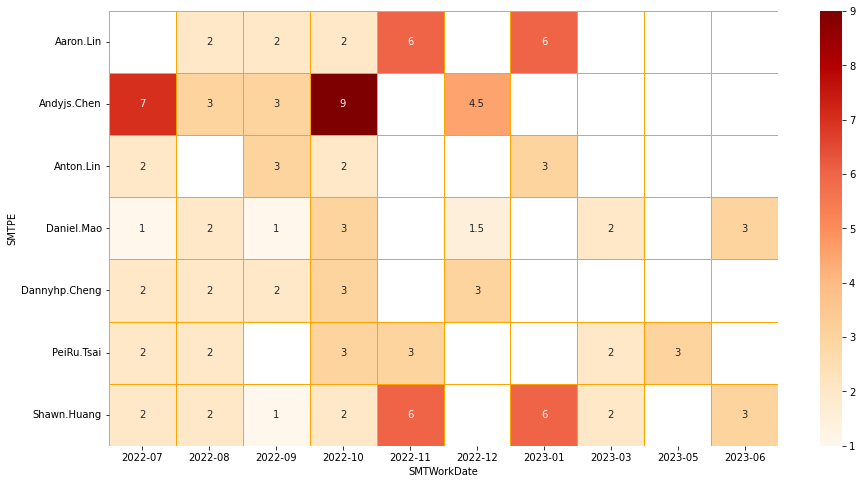

In [304]:
plt.figure(figsize=(15,8))
sns.heatmap(result.groupby(['SMTPE','SMTWorkDate'])['Score'].sum().unstack(level='SMTWorkDate'),cmap="OrRd", annot=True,linewidths=1, linecolor='Orange')
plt.savefig('SMTNPI_loading_overview',bbox_inches = "tight", facecolor='white', transparent=False, dpi=300)

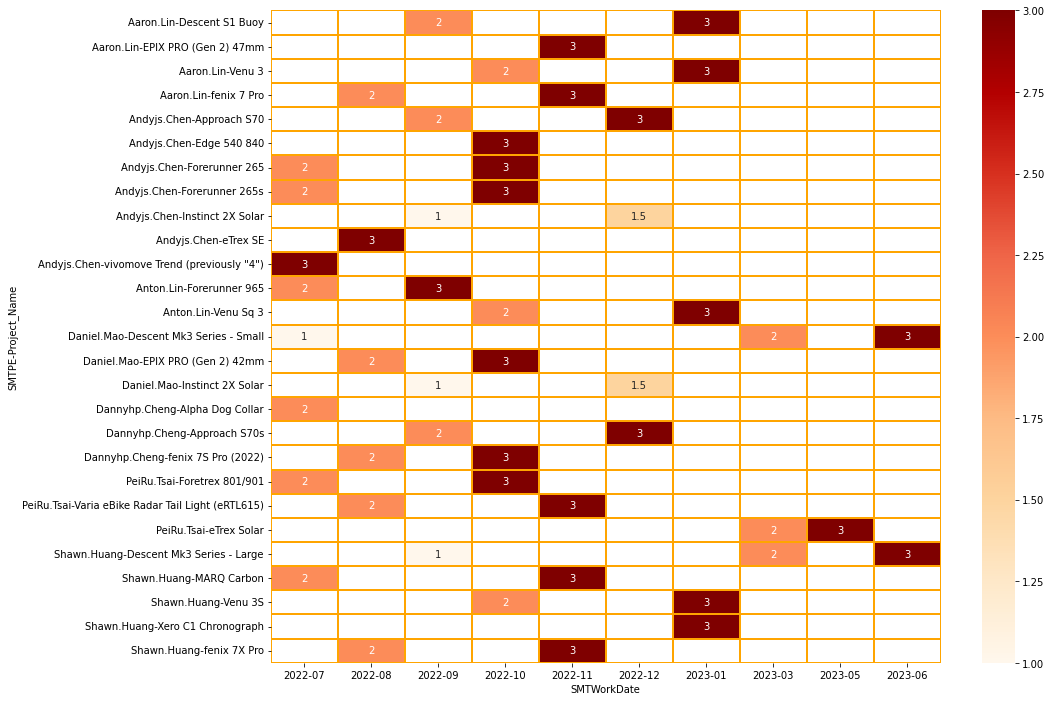

In [305]:
plt.figure(figsize=(15,12))
sns.heatmap(result_pivot,cmap="OrRd", annot=True,linewidths=1.5, linecolor='Orange')
plt.savefig('SMTNPI_loading_detail',bbox_inches = "tight", facecolor='white', transparent=False, dpi=300)

Excel writer

In [299]:

#with pd.ExcelWriter(getcwd()+'\data.xlsx', engine='openpyxl') as writer:
    #overall_show.to_excel(writer, sheet_name='overall')
    #auto_adjust_xlsx_column_width(overall_show, writer, sheet_name="overall", margin=5)
    
    #complete_rate.to_excel(writer, sheet_name='complete_rate')
    #auto_adjust_xlsx_column_width(complete_rate, writer, sheet_name="complete_rate", margin=5)
    
    #on_time_rate.to_excel(writer, sheet_name='on_time_rate')
    #auto_adjust_xlsx_column_width(on_time_rate, writer, sheet_name="on_time_rate", margin=5)